## 사전 준비

In [ ]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
import numpy as np 
import matplotlib.pyplot as plt

### 설치해야하는 패키지

In [ ]:
# !pip uninstall opencv-python
# !pip install opencv-python

In [ ]:
# !pip install -U albumentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
A.__version__

'1.1.0'

In [ ]:
# !pip install efficientnet-pytorch
# !pip install transformers

### 시드값 고정 및 GPU 설정
- 시드값을 고정하는 이유는 수행할 떄마다 같은 결과를 얻기 위해서

In [ ]:
import os
import random

seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)

random.seed(seed) # 파이썬 난수 생성기 시드 고정
np.random.seed(seed) # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed) # 파이토치 난수 생성기 시드 고정(CPU)
torch.cuda.manual_seed(seed) # 파이토치 난수 생성기 시드 고정(GPU)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정(멀티GPU)
torch.backends.cudnn.deterministic = True # 확정적 연산
torch.backends.cudnn.benchmark = False # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False # cudnn 사용 해제

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 1. 데이터 준비 과정

In [ ]:
import pandas as pd

data_path = '/content/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [ ]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


## 1-2 타깃값의 분포 확인

In [ ]:
healthy = train.loc[train['healthy'] == 1]
multiple_diseases = train.loc[train['multiple_diseases'] == 1]
rust = train.loc[train['rust'] == 1]
scab = train.loc[train['scab'] == 1]

([<matplotlib.patches.Wedge at 0x7fd7476eaa10>,
 [Text(0.6921787180836257, 0.8549202431993926, 'healthy'),
  Text(-0.3942932497177081, 1.0269044908008969, 'multiple_diseases'),
  Text(-1.0996317038245758, -0.028462535794632142, 'rust'),
  Text(0.5744651016901711, -0.9380777403499678, 'scab')],
 [Text(0.377552028045614, 0.4663201326542141, '28.3%'),
  Text(-0.21506904530056806, 0.5601297222550347, '5.0%'),
  Text(-0.5997991111770412, -0.015525019524344801, '34.2%'),
  Text(0.31334460092191146, -0.5116787674636187, '32.5%')])

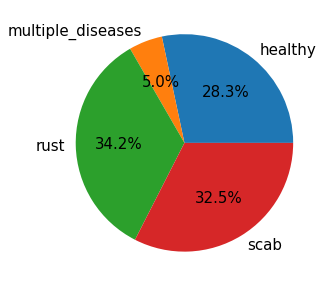

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size = 15)
plt.figure(figsize = (5,5))
label = ['healthy', 'multiple_diseases', 'rust', 'scab']

plt.pie([len(healthy), len(multiple_diseases),len(rust),len(scab)],
        labels = label, autopct = '%.1f%%')

## 1-3 이미지 확인

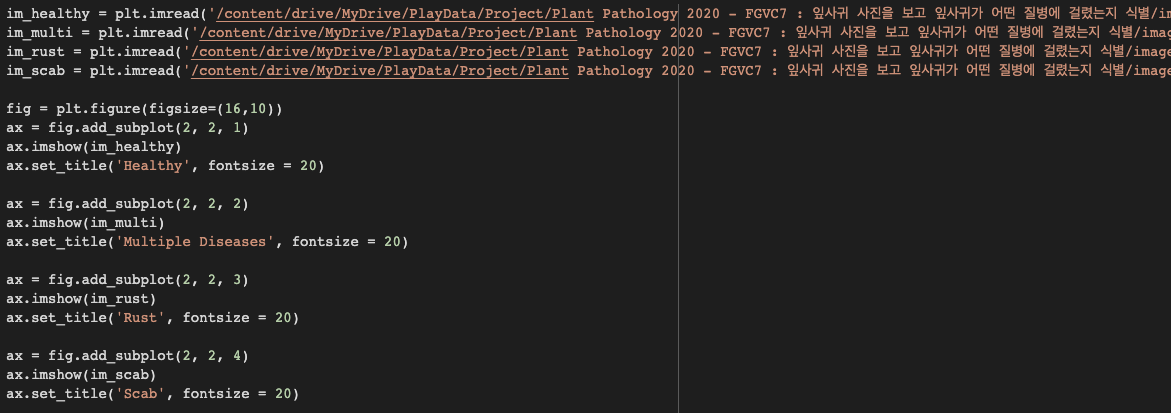

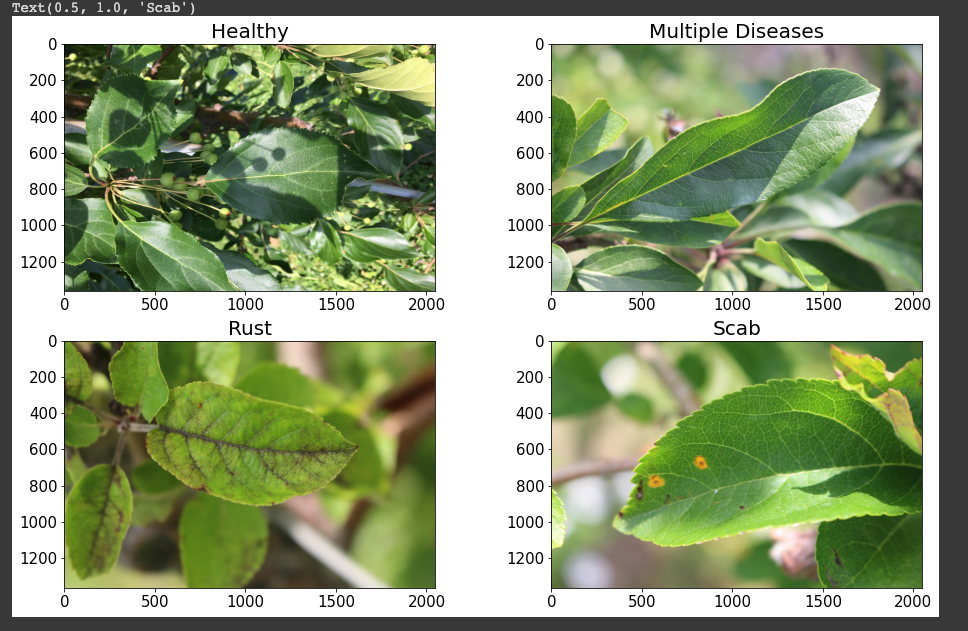

In [ ]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_id, rows = 2, cols = 3):
    assert len(img_id) <= rows * cols

    plt.figure(figsize = (15,8))
    grid = gridspec.GridSpec(rows, cols)

    for idx, img in enumerate(img_id):
        img_path = f'{data_path}/images/{img}.jpg'
        image = cv2.imread(img_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

In [ ]:
num_of_imgs = 6
last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]

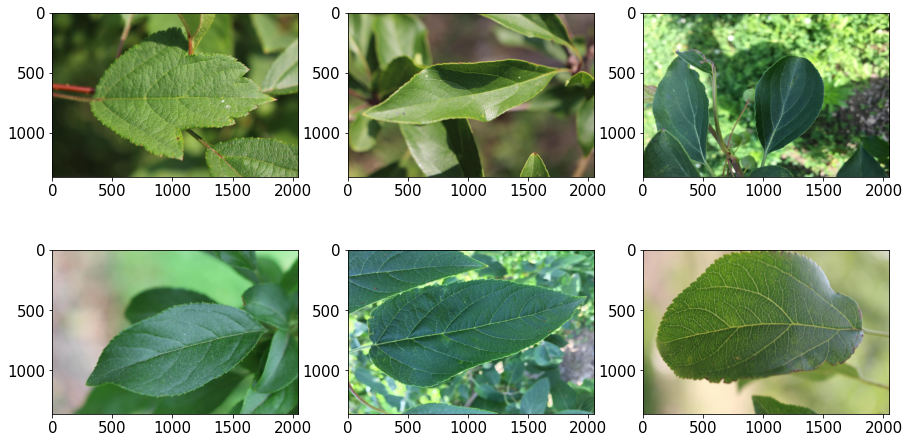

In [ ]:
show_image(last_healthy_img_ids)

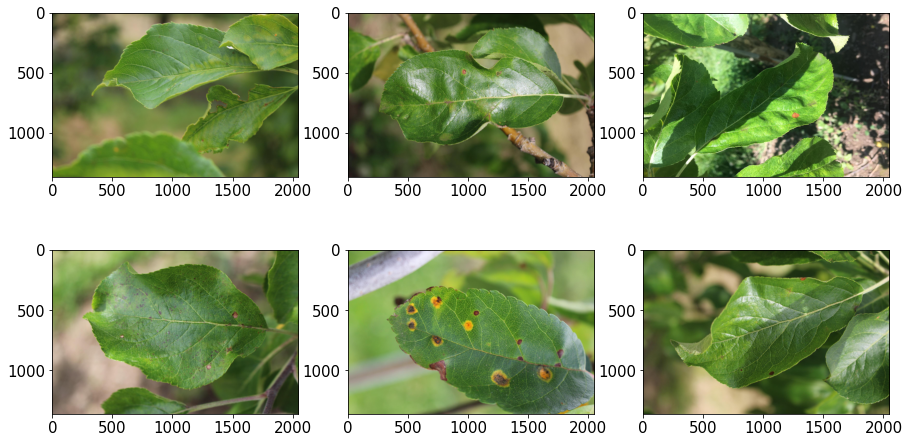

In [ ]:
show_image(last_multiple_diseases_img_ids)

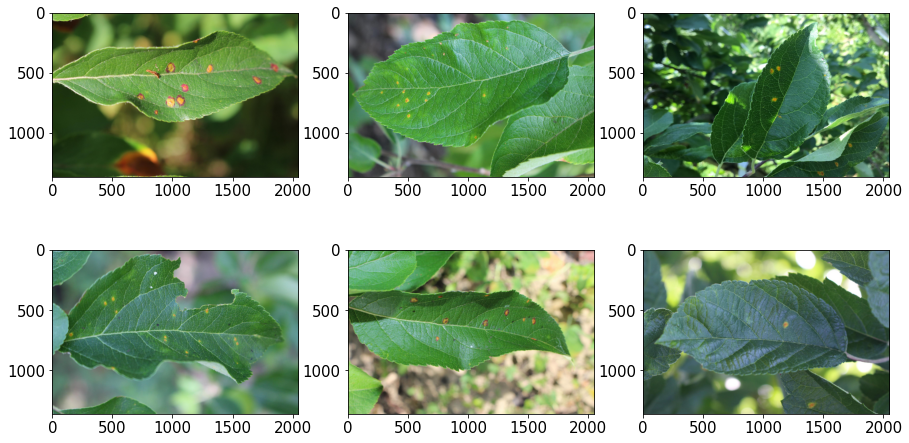

In [ ]:
show_image(last_rust_img_ids)

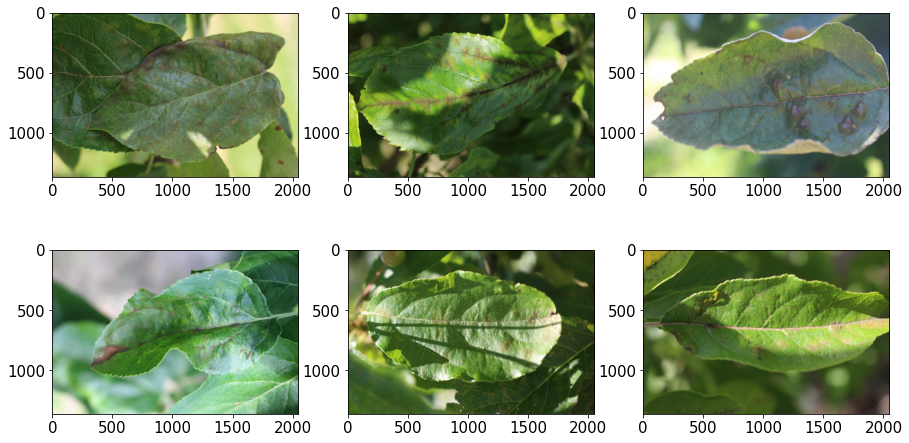

In [ ]:
show_image(last_scab_img_ids)

## 1-4 데이터셋 형성

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(train,
                               test_size = 0.1,
                               stratify = train[['healthy', 'multiple_diseases', 'rust', 'scab']],
                               random_state = 50)

In [ ]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스
import numpy as np

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    # 데이터셋 크기(갯수) 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]             # 이미지 ID
        img_path = self.img_dir + img_id + '.jpg' # 이미지 파일 경로
        image = cv2.imread(img_path)              # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        # 이미지 변환 
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환 
        if self.is_test:
            return image # 테스트용일 때
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스 
            label = np.argmax(self.df.iloc[idx, 1:5]) 
            return image, label # 훈련/검증용일 때

## 1-5 이미지 증강용 transformer

In [ ]:
## packages

!pip list
!pip uninstall opencv-python-headless==4.5.5.64
pip install opencv-python-headless==4.5.2.52
!pip install -U albumentations
!pip install transformers

In [ ]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650),       # 이미지 크기 조절 
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환 
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환 
    A.Normalize(),            # 정규화 변환 
    ToTensorV2()              # 텐서로 변환
])

# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절 
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

## 데이터셋, 데이터 로더 생성

In [ ]:
img_dir = '/content/images/'

dataset_train = ImageDataset(train, img_dir = img_dir, transform = transform_train)
dataset_valid = ImageDataset(valid, img_dir = img_dir, transform = transform_test)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size = batch_size,
                          shuffle = True, num_workers = 2)

loader_valid = DataLoader(dataset_valid, batch_size = batch_size,
                          shuffle = False, num_workers = 2)

### 멀티프로세싱

Dataloader에서 Multiprocess를 사용할 때 각 worker에는 base_seed + worker_id로 시드가 설정된다고 한다. 그런데, 다른 라이브러리의 seed는 이와 같지 않을 수 있다. worker마다 seed를 설정하는 함수를 dataloader 생성 시 worker_init_fn으로 넣어주자.

한편 빠른 전처리를 통해 CPU가 task를 바로바로 GPU로 던져줄 수 있다면 GPU는 쉬는시간 없이 계속 일을 하게 될겁니다. 머신러닝에서 가장 많은 시간을 소비하게 되는 구간이 GPU라는 것을 생각해봤을때 GPU는 놀면 안되겠죠. (일반적인 머신러닝 상황입니다. GPU, 모델의 종류 등에 따라 예외적인 상황이 있습니다)

In [ ]:
def seed_worker(worker_id): # 데이터 로더 시드값 고정
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator() # 제너레이터 생성
g.manual_seed(0) # 제너레이터 시드 고정

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size = batch_size,
                          shuffle = True, num_workers = 2, # 활용할 프로세스의 개수
                          worker_init_fn = seed_worker, generator = g)

loader_valid = DataLoader(dataset_valid, batch_size = batch_size,
                          shuffle = False, num_workers = 2,
                          worker_init_fn = seed_worker, generator = g)

# 2. 모델 형성 (transfer learning)

## pretrained 모델 사용(EfficientNet)

In [ ]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) 

model = model.to(device) # 장비 할당

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


## 손실함수, 옵티마이저, 스케줄러 설정

In [ ]:
import torch.nn as nn
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005, weight_decay = 0.0001)

In [ ]:
from transformers import get_cosine_schedule_with_warmup

epochs = 10 # 총 에폭

# 스케줄러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=len(loader_train)*3, # 옵티마이저에서 지정한 학습률로 몇번만에 도달하는가
                                            num_training_steps=len(loader_train)*epochs) # 모든 훈련을 마치는데 필요한 반복 횟수

# 3. 모델 훈련 및 검증

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 



# 총 에폭만큼 반복
for epoch in range(epochs):
    # 훈련

    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
        scheduler.step() # 스케줄러 학습률 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # 검증

    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [1/5] - 훈련 데이터 손실값 : 0.7257
에폭 [1/5] - 검증 데이터 손실값 : 0.2374 / 검증 데이터 ROC AUC : 0.9680


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [2/5] - 훈련 데이터 손실값 : 0.3675
에폭 [2/5] - 검증 데이터 손실값 : 0.1919 / 검증 데이터 ROC AUC : 0.9821


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [3/5] - 훈련 데이터 손실값 : 0.2755
에폭 [3/5] - 검증 데이터 손실값 : 0.1897 / 검증 데이터 ROC AUC : 0.9812


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [4/5] - 훈련 데이터 손실값 : 0.1752
에폭 [4/5] - 검증 데이터 손실값 : 0.1687 / 검증 데이터 ROC AUC : 0.9845


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [5/5] - 훈련 데이터 손실값 : 0.1398
에폭 [5/5] - 검증 데이터 손실값 : 0.1679 / 검증 데이터 ROC AUC : 0.9844


# 예측 및 평가
- 테스트 데이터를 총 4개로 출력
 - 일반 테스트
 - TTA 적용 테스트
 - 일반 테스트에 label smoothing 적용
 - TTA에 label smoothing 적용

In [ ]:
# 테스트 데이터 원본 데이터셋 및 데이터 로더
dataset_test = ImageDataset(test, img_dir=img_dir, 
                            transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

# TTA용 데이터셋 및 데이터 로더
dataset_TTA = ImageDataset(test, img_dir=img_dir, 
                           transform=transform_train, is_test=True)
loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size, 
                        shuffle=False, worker_init_fn=seed_worker,
                        generator=g, num_workers=2)

In [ ]:
model.eval() # 모델을 평가 상태로 설정 

preds_test = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds_test[i*batch_size:(i+1)*batch_size] += preds_part

In [ ]:
submission_test = submission.copy() # 제출 샘플 파일 복사

submission_test[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_test

TTA: Test Time Augmentation.
TTA는 말 그대로 Inference(Test) 과정에서 Augmentation 을 적용한 뒤 예측의 확률을 평균(또는 다른 방법)을 통해 도출하는 기법입니다. 모델 학습간에 다양한 Augmentation 을 적용하여 학습하였을시, Inference 과정에서도 유사한 Augmentation 을 적용하여 정확도를 높일 수 있습니다. 또는 이미지에 객체가 너무 작게 위치한 경우 원본 이미지, Crop 이미지를 넣는 등 다양하게 활용이 가능 합니다.

In [ ]:
num_TTA = 7 # TTA 횟수

preds_tta = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화 (TTA용)

# TTA를 적용해 예측
for i in range(num_TTA):
    with torch.no_grad():
        for i, images in enumerate(loader_TTA):
            images = images.to(device)
            outputs = model(images)
            # 타깃 예측 확률
            preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
            preds_tta[i*batch_size:(i+1)*batch_size] += preds_part

In [ ]:
preds_tta /= num_TTA 

In [ ]:
submission_tta = submission.copy() 

submission_tta[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_tta

In [ ]:
# test : 0.97043 tta : 0.96784
submission_test.to_csv('submission_test.csv', index=False)
submission_tta.to_csv('submission_tta.csv', index=False)

이러한 문제를 해결하기 위한 한 가지 가능한 방법이 label smoothing 입니다. 이진 분류 문제에서 label 은 0 또는 1로 주어집니다. label 이 1이라고 하는 것은 그것의 label 이 1 임을 100 % 확신한다는 뜻입니다. 하지만 반드시 그렇지 않을 수 있다는 것이 핵심 문제입니다. 왜냐하면 사람이 annotation 하는 것이기 때문에 실수의 가능성이 언제나 존재합니다. 이 때 발생할 수 있는 잘못된 loss 의 영향을 줄이기 위하여 label 을 0또는 1이 아니라 smooth 하게 부여하는 것이 label smoothing 의 아이디어입니다. 또한 label smoothing 은 mislabeling 된 데이터를 고려하기 위해 사용되는 것에 추가적으로 regularization에 도움을 주면서, model generalization 과 calibration 에 도움이 된다는 것이 알려져있습니다.


In [ ]:
def apply_label_smoothing(df, target, alpha, threshold):
    # 타깃값 복사
    df_target = df[target].copy()
    k = len(target) # 타깃값 개수
    
    for idx, row in df_target.iterrows():
        if (row > threshold).any():         # 임계값을 넘는 타깃값인지 여부 판단
            row = (1 - alpha)*row + alpha/k # 레이블 스무딩 적용  
            df_target.iloc[idx] = row       # 레이블 스무딩을 적용한 값으로 변환
    return df_target # 레이블 스무딩을 적용한 타깃값 반환

In [ ]:
alpha = 0.001 # 레이블 스무딩 강도
threshold = 0.999 # 레이블 스무딩을 적용할 임계값


submission_test_ls = submission_test.copy()
submission_tta_ls = submission_tta.copy()

target = ['healthy', 'multiple_diseases', 'rust', 'scab']

# 레이블 스무딩 적용
submission_test_ls[target] = apply_label_smoothing(submission_test_ls, target, 
                                                   alpha, threshold)
submission_tta_ls[target] = apply_label_smoothing(submission_tta_ls, target, 
                                                  alpha, threshold)

# test_ls : 0.96979
# tta_ls : 0.96722
submission_test_ls.to_csv('submission_test_ls.csv', index=False)
submission_tta_ls.to_csv('submission_tta_ls.csv', index=False)

#### 결과 : 학습의 부족인지, 일반 테스트의 결과가 가장 좋게 나옴

# 5. 질문 답변하기
- Q1) 어떤 옵티마이저, 로스 함수를 사용했는지?
 - 일반적으로 분류에서 가장 많이 사용하는 옵티마이저, 로스 함수 사용
 - optimizer : AdamW 
 - loss function : CrossEntropyLoss
- Q2) 처음 시도했던 Network Architecture는 어떤 종류인지?
 - ResNet
- Q3) 이후 시도해봤던 Network 들은 무엇인지?
 - EfficientNet을 버전을 바꿔가며 사용해봄(B 시리즈)
- Q4) 과대적합을 피하기 위해 했던 작업들은 무엇인지?
 - scheduler
 - TTA(Test Time Augmentation)
 - label smoothing
- Q5) 중요 하이퍼파라미터 어떻게 설정했는지? 이유? (배치사이즈(batch size), 에폭(epoch), 학습률(learning rate) 등)
 - 배치사이즈는 4 ~ 256 중 선택 하는것이 좋다는 정보를 얻음. 데이터 값이 그렇게 크지 않으니 가장 작은 값인 4를 기준으로 설정
 - 에폭 : 5 , 10 으로 설정했으나 사실 38로도 시도해봤음(코랩에서는 리소스 부족으로 그래픽 카드 사용 불가, 캐글로 확인)
 - 학습률 : 0.5, 0.05, 0.005, 0.00006 시도했을 떄 0.00006이 가장 잘 나옴